In [82]:
import pickle
import glob
import numpy
import matplotlib.pyplot as plt
import traceback
from astropy.stats import mad_std

In [2]:
pickles = glob.glob('*.pickle')

Text(0.5, 0, 'gain/deg')

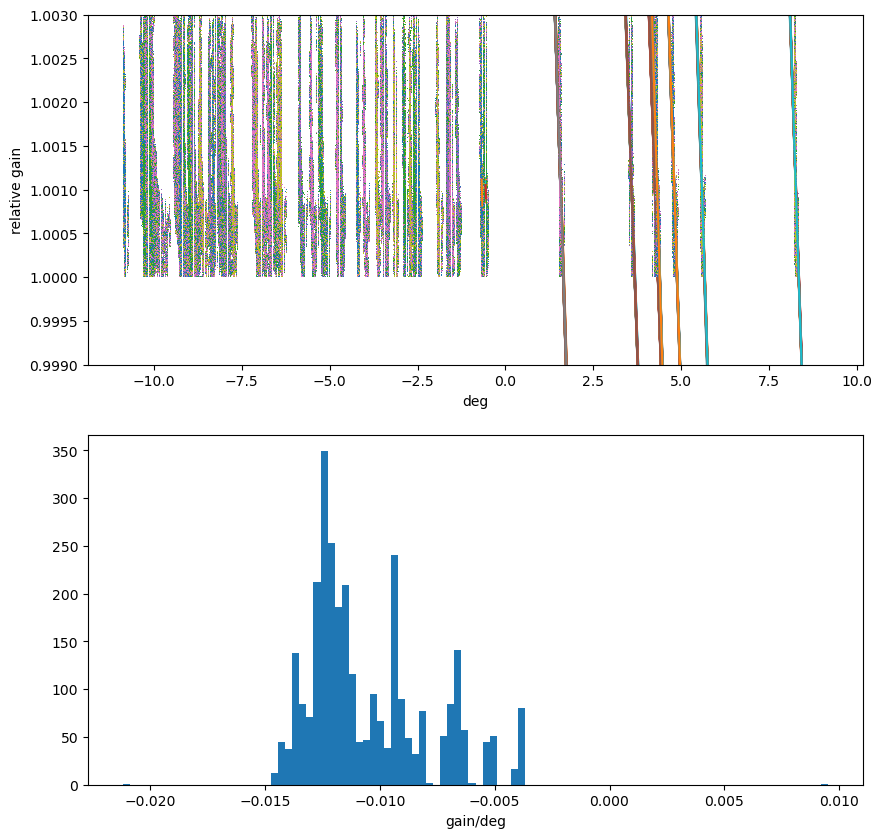

In [3]:
fig,axs=plt.subplots(2,1,figsize=(10,10),sharex=False,sharey=False)

slopes = {}
sigmas = []
temps = {}
mjd = {}

for apickle in pickles:
    try:
#        print(apickle)
        with open(apickle,'rb') as f:
            data=pickle.load(f)
        name=list(data.keys())[0]
        for amp in data[name]:
            axs[0].plot(data[name][amp]['x'],data[name][amp]['y'],",")

            xmin = data[name][amp]['x'].min()
            xmax = data[name][amp]['x'].max()

            x=numpy.arange(xmin*0.9,xmax*1.1,0.001)
            y=data[name][amp]['slope']*x+data[name][amp]['intercept']
            sigmas.append(data[name][amp]['std_err'])
            axs[0].plot(x,y,'-')
            slopes.setdefault( name, {} )[amp] = data[name][amp]['slope'] 
            temps.setdefault( name, {} )[amp] = data[name][amp]['x'].max()
            mjd.setdefault( name, {} )[amp] = data[name][amp]['mjd']


    except:
        traceback.print_exc()
axs[1].hist( numpy.array([ list(a.values()) for a in slopes.values() ]).flatten(), bins=100 ) #, range=(-0.0015,-0.000) )
axs[0].set_ylim(0.999,1.003)
axs[0].set_xlabel('deg')
axs[0].set_ylabel('relative gain')
axs[1].set_xlabel('gain/deg')

-1.15e-02 (+/-) 6.65e-07


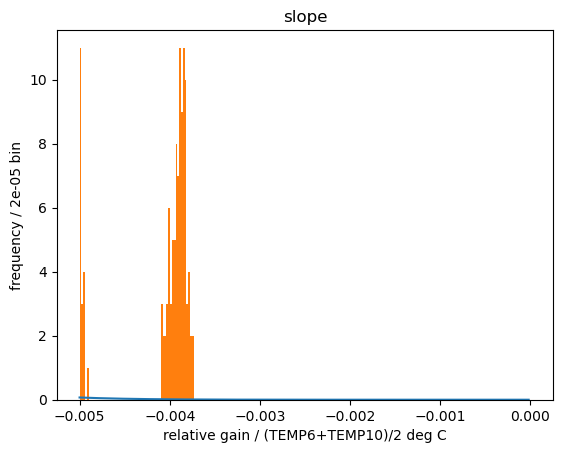

In [4]:
dx=0.00002
xmin= -0.005 # -0.0015
xmax=0.
x=numpy.arange(xmin,xmax,dx)
relgain=numpy.array([ list(a.values()) for a in slopes.values() ]).flatten()
mu=numpy.median(relgain)
sigma=mad_std(relgain)
print(f"{mu:.2e} (+/-) {sigma/len(relgain):.2e}")
# relgain.mean())
plt.plot(x,numpy.exp( -(x-mu)**2/(2*sigma**2) )/numpy.sqrt(2*numpy.pi*sigma**2)*len(relgain)*dx)
plt.hist( numpy.array([ list(a.values()) for a in slopes.values() ]).flatten(), bins=int((xmax-xmin)/dx), range=(xmin,xmax) )
plt.xlabel('relative gain / (TEMP6+TEMP10)/2 deg C')
plt.ylabel(f'frequency / {dx} bin')
plt.title('slope')
plt.savefig('relgain.pdf')

Text(0, 0.5, 'slopes')

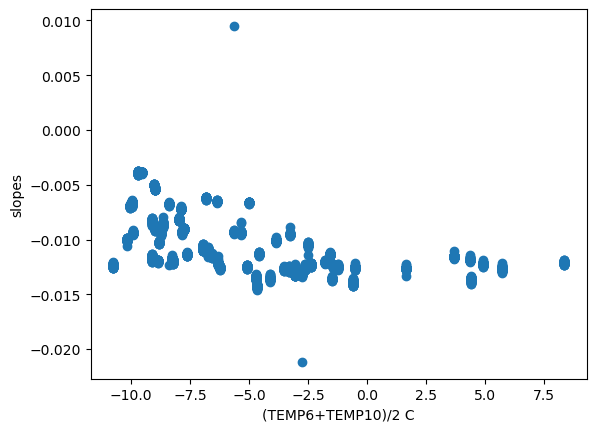

In [5]:
plt.plot(
    numpy.array([ list(a.values()) for a in temps.values() ]).flatten(),
    numpy.array([ list(a.values()) for a in slopes.values() ]).flatten(),
    "o"
)
plt.xlabel('(TEMP6+TEMP10)/2 C')
plt.ylabel('slopes')

Text(0.5, 0, 'MJD')

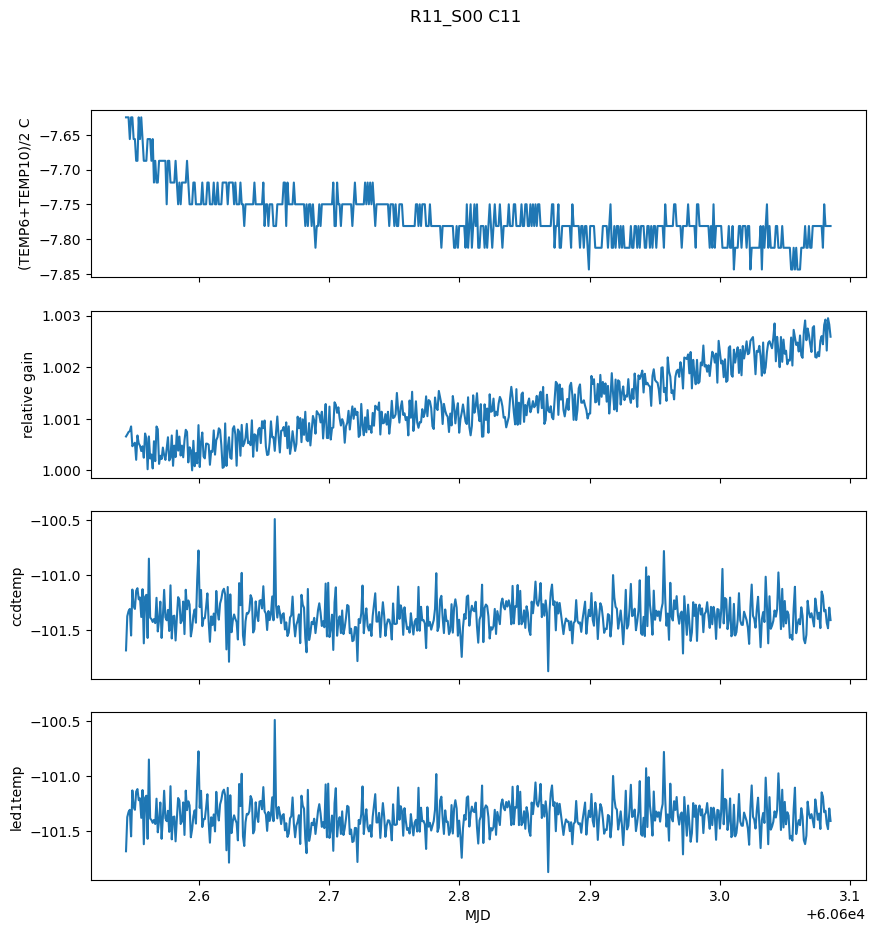

In [6]:
sensor = 'R11_S00'
segment='C11'

with open(f'{sensor}.pickle','rb') as f:
    data=pickle.load(f)

fig,axs=plt.subplots(4,1,figsize=(10,10),sharex=True,sharey=False)

plt.suptitle(f'{sensor} {segment}')
axs[0].plot(data[sensor][segment]['mjd'], data[sensor][segment]['x'] )
axs[0].set_ylabel('(TEMP6+TEMP10)/2 C')
axs[1].plot(data[sensor][segment]['mjd'], data[sensor][segment]['y'] )
axs[1].set_ylabel('relative gain')
axs[2].plot(data[sensor][segment]['mjd'], data[sensor][segment]['ATEMPU'] )
axs[2].set_ylabel('ccdtemp')
axs[3].plot(data[sensor][segment]['mjd'], data[sensor][segment]['ATEMPU'] )
axs[3].set_ylabel('led1temp')
plt.xlabel('MJD')


In [7]:
data[sensor]['C11']['mjd'].min()

60602.54366387753

Text(0, 0.5, 'relgain')

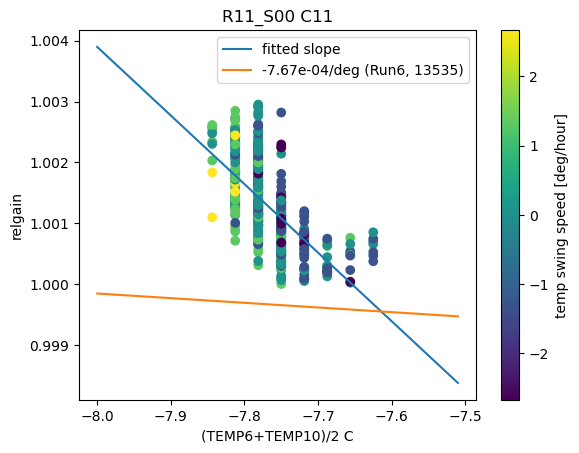

In [8]:
import numpy

diff=numpy.diff(data[sensor][segment]['x'])/( numpy.diff(data[sensor][segment]['mjd'] ) * 24  )  # deg / day = deg / ( 24 * hour )
#c=(diff-diff.min())/(diff.max()-diff.min())
p=plt.scatter(data[sensor][segment]['x'][:-1], data[sensor][segment]['y'][:-1],c=diff)
plt.colorbar(p,label='temp swing speed [deg/hour]')
x=numpy.arange(-8,-7.5,0.01)
plt.plot(x, data[sensor][segment]['slope']*x+data[sensor][segment]['intercept'], label='fitted slope')
plt.plot(x, -7.67e-04*x+data[sensor][segment]['intercept']+0.08, label='-7.67e-04/deg (Run6, 13535)')

plt.title(f"{sensor} {segment}")
plt.legend()
plt.xlabel('(TEMP6+TEMP10)/2 C')
plt.ylabel('relgain')

(array([ 17., 104., 288.,  43.,  75.,  15.,   8.,   1.,   2.,   1.]),
 array([0.00097469, 0.00097586, 0.00097703, 0.00097821, 0.00097938,
        0.00098055, 0.00098172, 0.00098289, 0.00098407, 0.00098524,
        0.00098641]),
 <BarContainer object of 10 artists>)

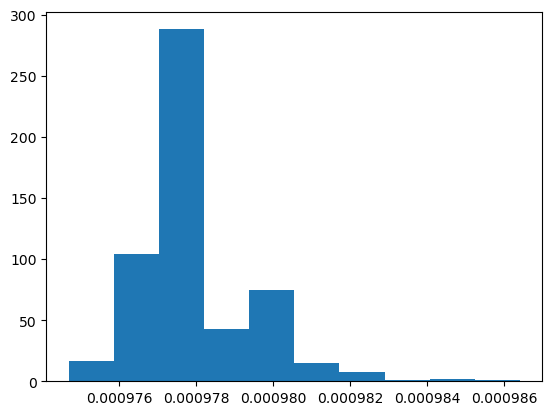

In [9]:
plt.hist(numpy.diff(data[sensor][segment]['mjd']))

In [10]:
from astropy.time import Time

In [11]:
Time(60597.43150461791, format='mjd').isot

'2024-10-14T10:21:21.999'

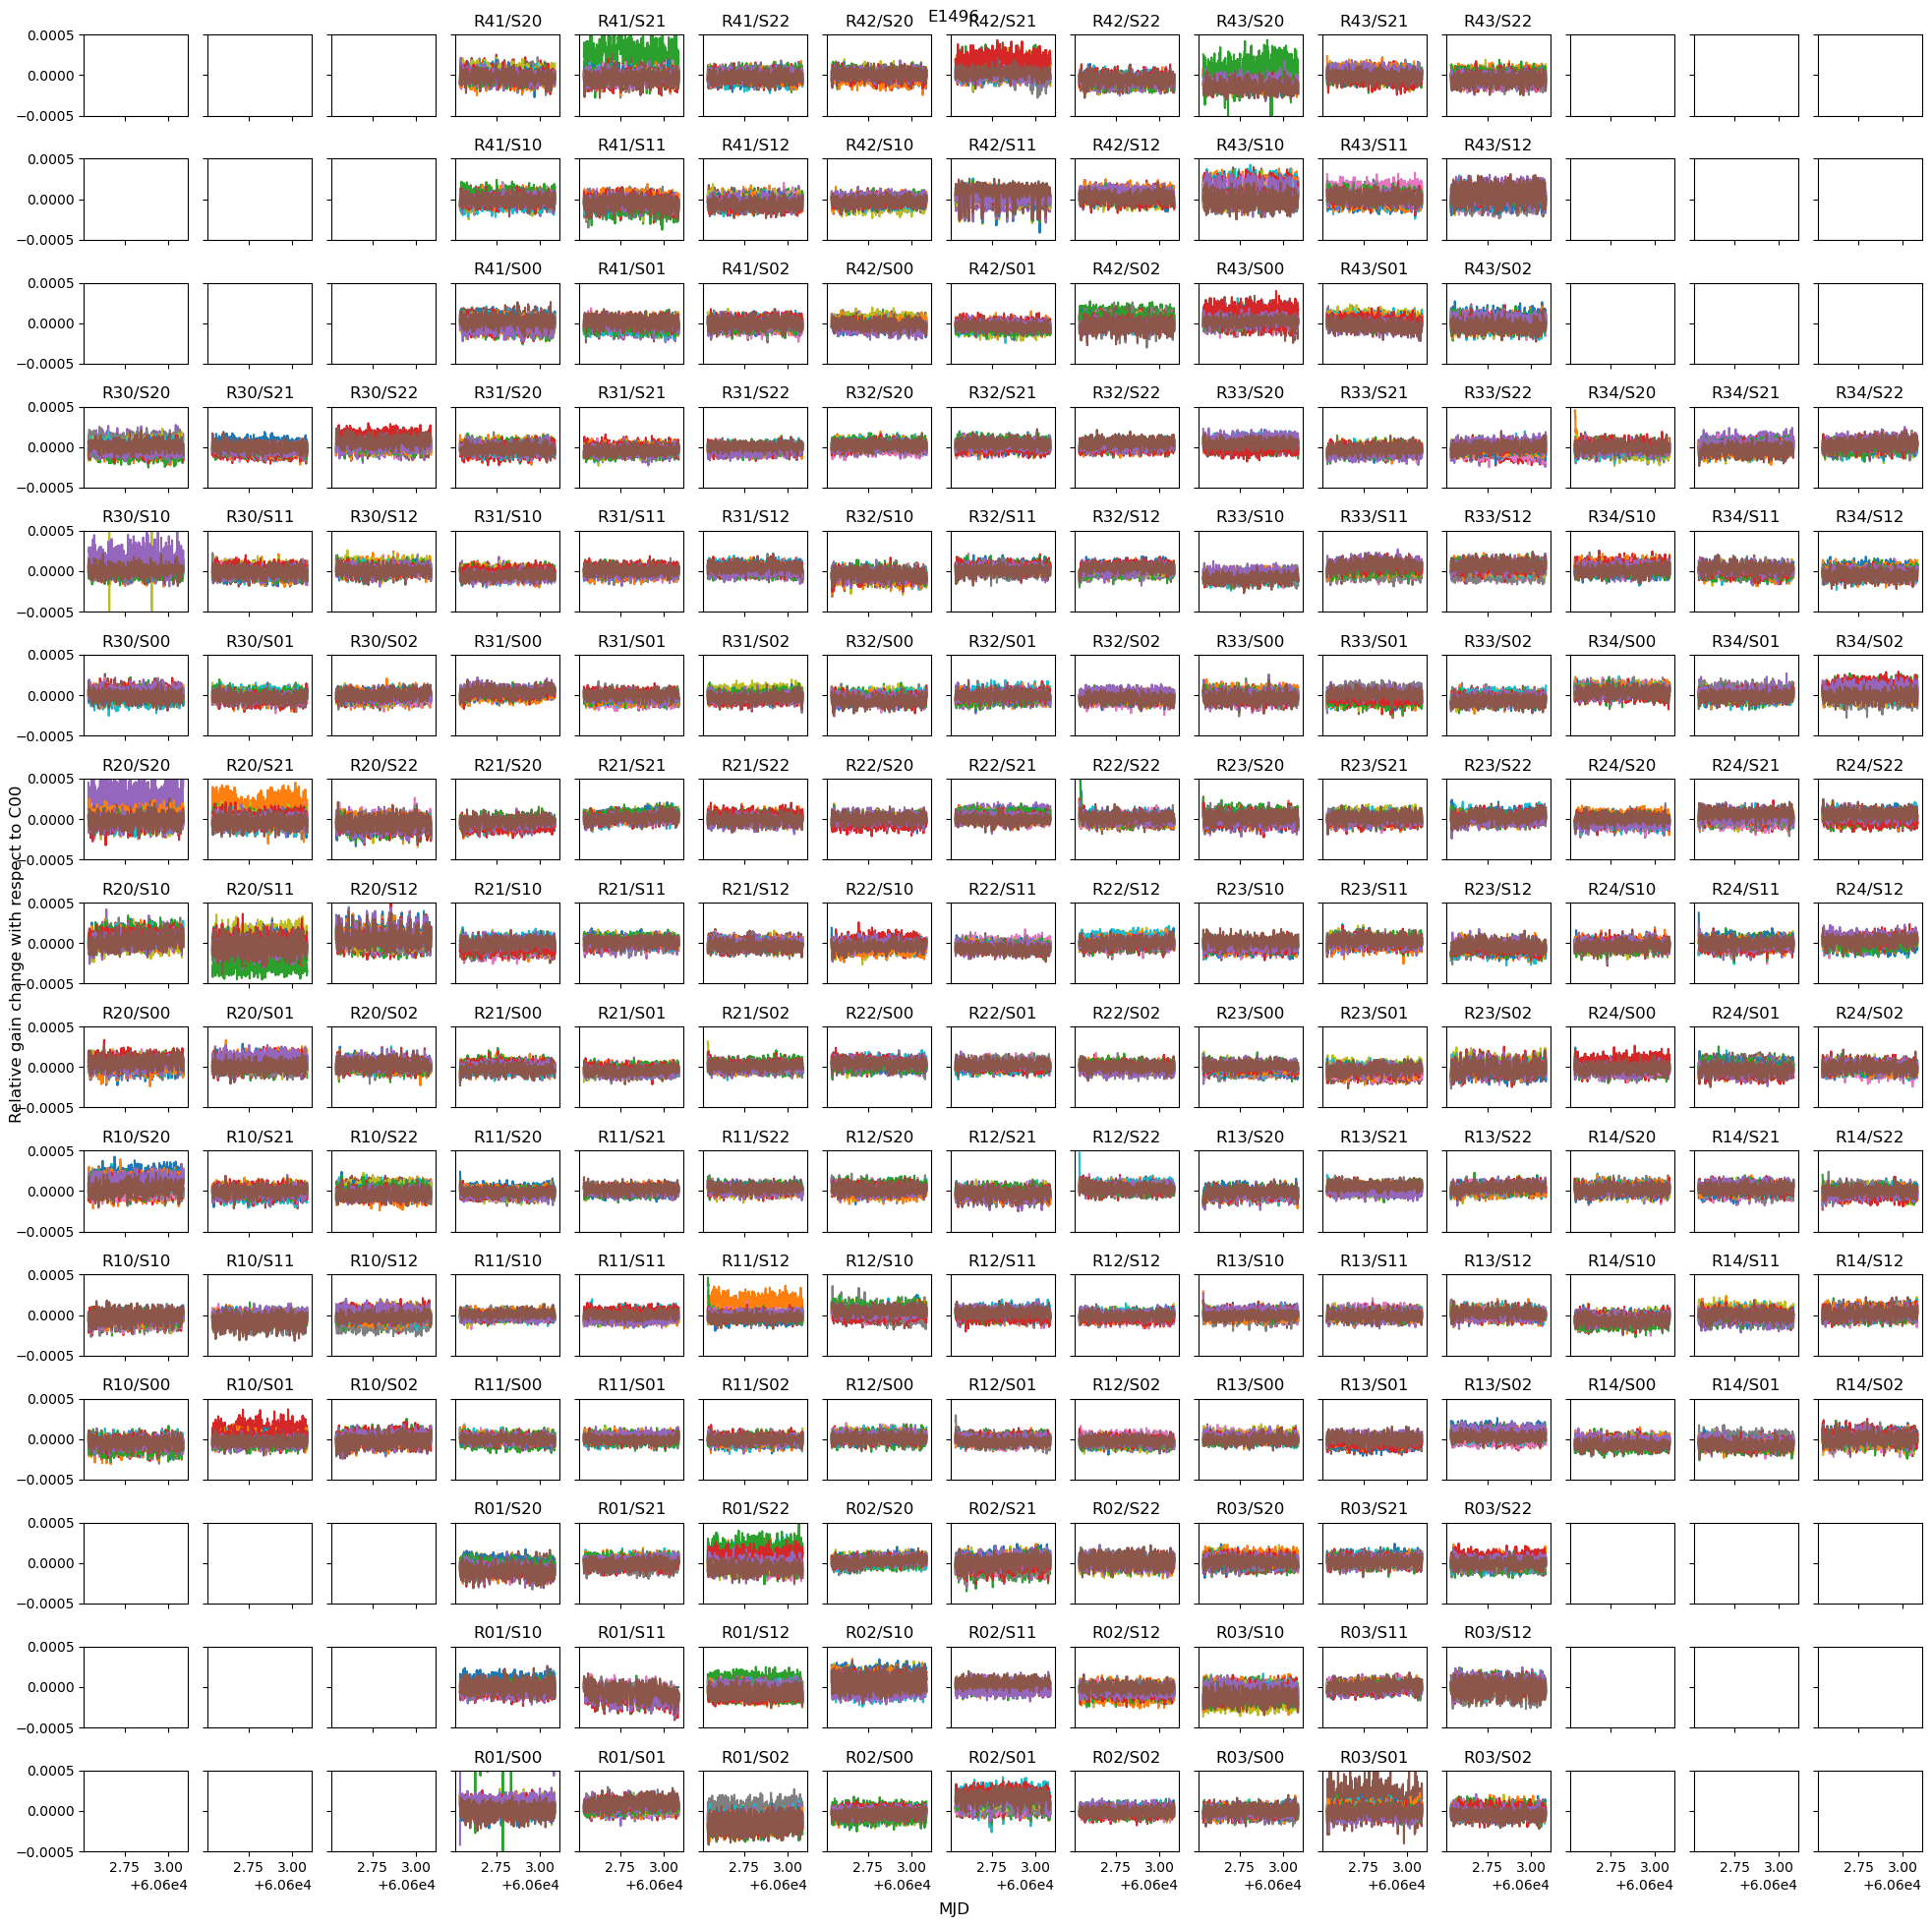

In [93]:
import itertools
segments = list(map(lambda x: f"C{x[0]}{x[1]}",itertools.product(range(2), range(8))))
sensors = list(map(lambda x: f"S{x[0]}{x[1]}", itertools.product(range(3)[::-1], range(3))))
rafts = list(map(lambda x: f"R{x[0]}{x[1]}", itertools.product(range(5),range(5))) )

run = 'E1496'
fig,axs=plt.subplots(15,15,figsize=(20,20),sharex=True,sharey=True)

for raft in rafts:    
    for sxx in sensors:
        n,m=[ int(x) for x in raft[1:]]
        i,j=[ int(x) for x in sxx[1:]] 
        ax=axs[3*(4-n)+2-i,3*m+j]
        sensor=f"{raft}_{sxx}"
        try:
            with open(f'{sensor}.pickle','rb') as f:
                data=pickle.load(f)
            
            for segment in segments:
                ax.set_title(f"{raft}/{sxx}")
                ax.plot(data[sensor][segment]['mjd'],
                        data[sensor][segment]['y'].array-data[sensor][segments[0]]['y'].array, '-' )
                ax.set_ylim(-5e-4,5e-4)
        except:
            pass
fig.supylabel('Relative gain change with respect to C00')
fig.supxlabel('MJD')
fig.suptitle(f'{run}')
plt.tight_layout()
plt.savefig(f'{run}gainoverall.png')

In [79]:
[ x for x in raft ]

['R', '2', '2']